
Optimization Results:
Best Fitness: 0.31
Optimal Dosage Schedule: [0.         0.         0.         0.         0.         5.38609771
 5.4       ]


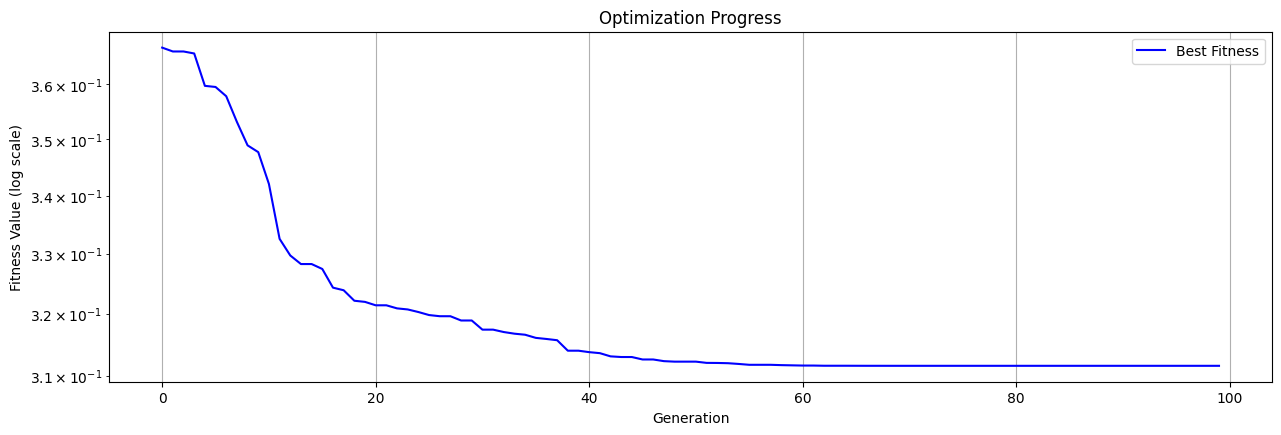

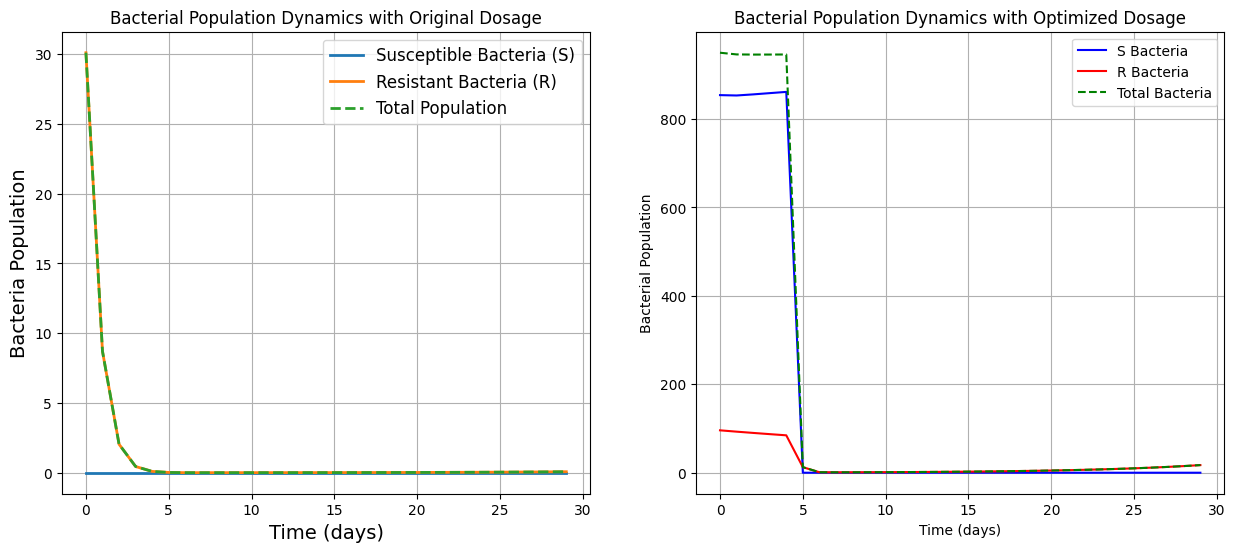

Optimized Total Dosage:  10.786097705636875


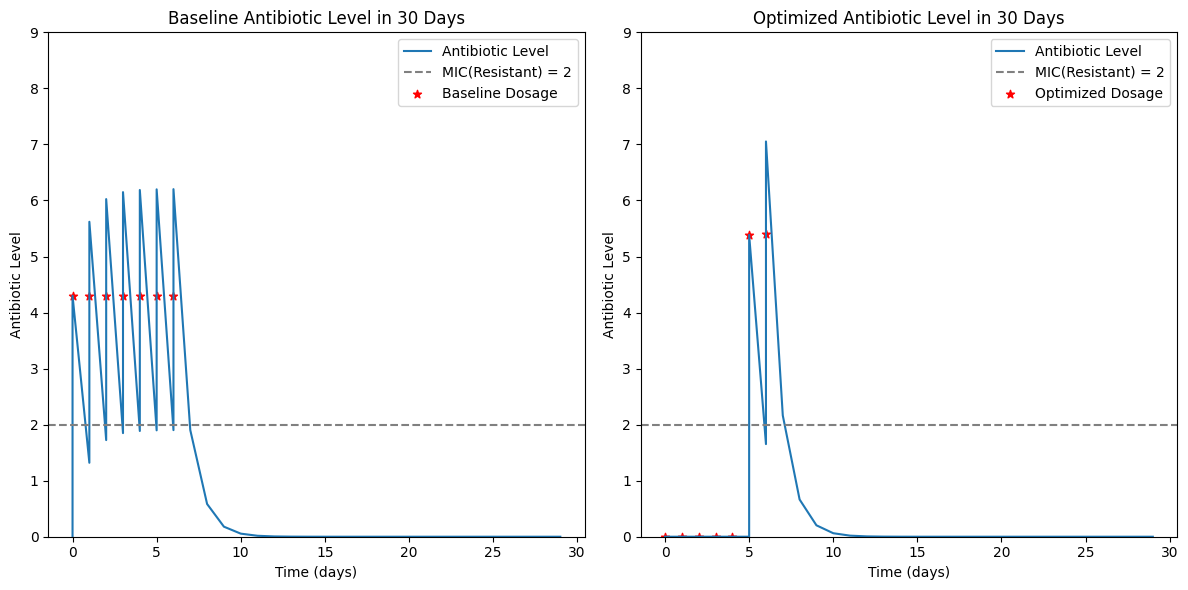

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns

def AR(C, maxR,micR, min_growth, n):
    """
    Calculates the susceptible bacterial death rate by antibiotic
    Parameters:
    C (float): Antibiotic concentration.
    maxR: maximum growth rate of resistant bacteria.
    min: minimum growth rate of resistant bacteria
    ER50: the antibiotic concentration when kill rate is at Emax/2
    n (float): Hill coefficient indicating the steepness of the curve.

    Returns:
    float: Bacterial death rate.
    """
    ERmax = maxR - min_growth

    return (ERmax * np.power(C/micR, n)) / (np.power(C/micR, n) - min_growth/maxR)

def AS(C, maxS,micS, min_growth, n):
    """
    Calculates the resistant bacterial death rate by antibiotic

    Parameters:
    C (float): Antibiotic concentration.
    maxS: maximum growth rate of susceptible bacteria.
    min: minimum growth rate of bacteria
    ES50: the antibiotic concentration when kill rate is at Emax/2
    n (float): Hill coefficient indicating the steepness of the curve.

    Returns:
    float: Bacterial death rate.
    """
    ESmax = maxS - min_growth

    return (ESmax * np.power(C/micS, n)) / (np.power(C/micS, n)  - min_growth/maxS)


def antibiotic(D, k, t_eval):
    """
    Simulates the concentration of an antibiotic over time given a dosage schedule and degradation rate.
    
    Parameters:
        D (array): Dosage schedule, where D[i] is the dosage administered on day i.
        k (float): Daily degradation rate of the antibiotic.
        t_eval (array): Time points to evaluate the antibiotic concentration.
        
    Returns:
        tuple:
            C_end_of_day (array): Antibiotic concentration at the end of each day.
            C_after_dose (array): Antibiotic concentration immediately after the dosage is administered.
    """
    # Initialize arrays to store antibiotic concentrations at the end of the day and after each dose
    C_end_of_day = np.zeros(len(t_eval))
    C_after_dose = np.zeros(len(t_eval))

    # Iterate through each time point in t_eval
    for index in range(len(t_eval)):
        # If within the dosage schedule (before exceeding the length of D)
        if index < len(D):
            if index == 0:
                C_end_of_day[index] = 0
                C_after_dose[index] = max(0, D[index])
            else:
                C_end_of_day[index] = max(0, C_after_dose[index - 1] * (1-k))
                C_after_dose[index] = max(0, D[index] + C_end_of_day[index])
        else: # If beyond the dosage schedule (no more doses in D)
            if C_after_dose[index - 1] > 0:
                C_end_of_day[index] = max(0, C_after_dose[index - 1] * (1-k))
                C_after_dose[index] = max(0, C_end_of_day[index])
            else:
                C_end_of_day[index] = 0
                C_after_dose[index] = 0

    return C_end_of_day, C_after_dose

def results(S0, R0, t_eval, r, theta, a, K, D, k, hgt_rate, maxS, micS, maxR, micR, min_growth, n):
    """
    Simulates the growth and dynamics of sensitive (S) and resistant (R) bacteria populations under antibiotic treatment.

    Parameters:
        S0 (float): Initial population of sensitive bacteria.
        R0 (float): Initial population of resistant bacteria.
        t_eval (array): Time points to evaluate the bacterial populations.
        r (float): Natural growth rate of the bacteria.
        theta (float): Natural death rate of the bacteria.
        a (float): Fitness cost of resistance (reduces growth of resistant bacteria).
        K (float): Carrying capacity of the environment.
        D (array): Dosage schedule for the antibiotic.
        k (float): Antibiotic degradation rate.
        hgt_rate (float): Horizontal gene transfer rate between sensitive and resistant bacteria.
        maxS (float): Maximum killing rate of the antibiotic for sensitive bacteria.
        micS (float): Minimum inhibitory concentration for sensitive bacteria.
        maxR (float): Maximum killing rate of the antibiotic for resistant bacteria.
        micR (float): Minimum inhibitory concentration for resistant bacteria.
        min_growth (float): Minimum bacterial growth rate under antibiotic pressure.
        n (float): Hill coefficient for antibiotic effect (steepness of killing curve).

    Returns:
        tuple:
            S_results (array): Population of sensitive bacteria over time.
            R_results (array): Population of resistant bacteria over time.
    """
    # Initialize arrays to store the results
    S_results = np.zeros(len(t_eval)) # susceptible
    R_results = np.zeros(len(t_eval)) # resistanct
    _, C_schdl = antibiotic(D, k, t_eval)
    
    # Initialize population
    S = S0
    R = R0

    # time step for simulation
    dt = 1.0 

    # Loop over each time point
    for i, t in enumerate(t_eval):
        C_current = C_schdl[i] if i < len(C_schdl) else 0

        # Calculate growth, death, and antibiotic effects for sensitive bacteria
        growth_S = r * S * (1 - (S + R) / K)
        death_S = theta * S
        hgt_loss = hgt_rate * S * R
        antibiotic_death_S = AS(C_current, maxS,micS, min_growth, n) * S

        # Calculate growth, death, and antibiotic effects for resistant bacteria
        growth_R = r * R * (1 - (S + R) / K) * (1 - a)
        death_R = theta * R
        hgt_gain = hgt_rate * S * R
        antibiotic_death_R = AR(C_current, maxR, micR, min_growth, n) * R

        # Calculate changes in population for sensitive and resistant bacteria
        dS = (growth_S - death_S - hgt_loss - antibiotic_death_S) * dt
        dR = (growth_R - death_R + hgt_gain - antibiotic_death_R) * dt

        # Update populations, ensuring they remain non-negative
        S = max(0, S + dS)
        R = max(0, R + dR)
        S_results[i] = S
        R_results[i] = R

    return S_results, R_results

# initailizing parameters
params = {
    't_eval': range(0, 30),
    't_half': 1.2,
    'k': np.log(2),  
    'S0': 900,
    'R0': 100,
    'K': 1000,
    'r': 1,
    'theta': 0.05,
    'a': 0.8,
    'maxR': 0.3,
    'maxS': 0.4,
    'n': 1.1,
    'min_growth': -6.5,
    'hgt_rate': 0.00001,
    'micR': 2,
    'micS': 1
}

D = [4.3]*7

# generate bacteria dynamic with initial dosage
S_results_org, R_results_org = results(params['S0'], params['R0'], params['t_eval'], 
                             params['r'], params['theta'], params['a'], 
                             params['K'], D, params['k'], params['hgt_rate'],
                             params['maxS'], params['micS'], params['maxR'], 
                             params['micR'], params['min_growth'], params['n'])



class GAParameters:
    population_size: int = 1000
    generations: int = 100
    mutation_rate: float = 0.5
    crossover_rate: float = 0.5
    dose_min: float = 0
    dose_max: float = 5.4
    treatment_days: int = 7
    total_dosage: float = 5.4*7

class GeneticOptimizer:
    def __init__(self, params: GAParameters, system_params: dict):
        self.params = params
        self.system_params = system_params
        self.best_solution = None
        self.best_fitness = float('inf')
        self.fitness_history = []
    
    def fitness_function(self, dosage):
        """
        Computes the fitness score for a given dosage schedule based on bacterial growth dynamics and antibiotic treatment.

        Parameters:
        dosage (list): Dosage schedule for the antibiotic treatment.

         Returns:
        float: Fitness score combining bacterial population dynamics and dosage usage.
        """
        # Simulate the dynamics of sensitive and resistant bacteria for the given dosage schedule
    
        S_results, R_results = results(
            self.system_params['S0'],
            self.system_params['R0'],
            self.system_params['t_eval'],
            self.system_params['r'],
            self.system_params['theta'],
            self.system_params['a'],
            self.system_params['K'],
            dosage.tolist(),
            self.system_params['k'],
            self.system_params['hgt_rate'],
            self.system_params['maxS'],
            self.system_params['micS'],
            self.system_params['maxR'],
            self.system_params['micR'],
            self.system_params['min_growth'],
            self.system_params['n']
        )
    
        # Number of time points for the simulation
        time_points = len(S_results)

        # computing max load, dosage, fianl bacteria for normalization
        # not treating bacteria with antibiotic
        D_min = [0]*7
        S_results_max, R_results_max = results(self.system_params['S0'], 
                                               self.system_params['R0'], 
                                               self.system_params['t_eval'], 
                                               self.system_params['r'], 
                                               self.system_params['theta'], 
                                               self.system_params['a'], 
                                               self.system_params['K'], 
                                               D_min, 
                                               self.system_params['k'], 
                                               self.system_params['hgt_rate'],
                                               self.system_params['maxS'], 
                                               self.system_params['micS'], 
                                               self.system_params['maxR'], 
                                               self.system_params['micR'], 
                                               self.system_params['min_growth'], 
                                               self.system_params['n'])
    
        max_total_bacteria = np.sum(S_results_max + R_results_max) # max total bacteria
        max_dosage = self.params.total_dosage  # max dosage
        max_final = S_results_max[-1]+R_results_max[-1] # max final bacteria level
        
        # weights on different terms
        w1 = 1 # total bacteria weight
        w2 = 1 # total dosage weight
        w3 = 10 # final bacteria weight
        
        bacteria_level = np.array(S_results) + np.array(R_results)
        final_bacteria = bacteria_level[-1]
        total_bacteria = np.sum(bacteria_level)
        total_dose = np.sum(dosage)
        
        return w1*total_bacteria/max_total_bacteria + w2*total_dose/max_dosage+ w3*final_bacteria/max_final
        

        
    def initialize_population(self):
        total_dose = self.params.total_dosage
        population = []
        for _ in range(self.params.population_size):
            individual = np.zeros(self.params.treatment_days)
            remaining_dose = total_dose
            for i in range(self.params.treatment_days - 1):
                max_possible = remaining_dose - (self.params.treatment_days - i - 1) * self.params.dose_min
                if max_possible < self.params.dose_min:
                    dose = self.params.dose_min
                else:
                    dose = np.random.uniform(self.params.dose_min, min(max_possible, self.params.dose_max))
                individual[i] = dose
                remaining_dose -= dose

            individual += np.random.uniform(-0.01, 0.01, size=self.params.treatment_days)
            individual = np.clip(individual, self.params.dose_min, self.params.dose_max)
            population.append(individual)
        return population


    def mutate(self, individual):
        mutated = individual.copy()
        if random.random() < self.params.mutation_rate:
            idx1, idx2 = random.sample(range(len(mutated)), 2)
            max_transfer = min(
                mutated[idx1] - self.params.dose_min, 
                self.params.dose_max - mutated[idx2] 
            )
            if max_transfer > 0:
                transfer = random.uniform(0, max_transfer)
                mutated[idx1] -= transfer
                mutated[idx2] += transfer
            random_idx = random.randint(0, len(mutated) - 1)
            mutated[random_idx] += np.random.uniform(-0.05, 0.05)
            mutated = np.clip(mutated, self.params.dose_min, self.params.dose_max)
        return mutated

    
    def select_parent(self, population, fitness_values):
        tournament_size = 3
        tournament_idx = np.random.choice(
            len(population),
            tournament_size,
            replace=False
        )
        tournament_fitness = fitness_values[tournament_idx]
        winner_idx = tournament_idx[np.argmin(tournament_fitness)]
        return population[winner_idx]

    def optimize(self):
        population = self.initialize_population()
        
        for generation in range(self.params.generations):
            fitness_values = np.array([
                self.fitness_function(ind) for ind in population
            ])
            
            min_fitness_idx = np.argmin(fitness_values)
            if fitness_values[min_fitness_idx] < self.best_fitness:
                self.best_fitness = fitness_values[min_fitness_idx]
                self.best_solution = population[min_fitness_idx].copy()
            
            self.fitness_history.append(self.best_fitness)
            
            new_population = []
            if self.best_solution is not None:
                new_population.append(self.best_solution.copy())
            
            while len(new_population) < self.params.population_size:
                child1 = self.select_parent(population, fitness_values)
                child2 = self.select_parent(population, fitness_values)
                # child1, child2 = self.crossover(parent1, parent2)
                new_population.extend([
                    self.mutate(child1),
                    self.mutate(child2)
                ])
            
            population = new_population[:self.params.population_size]
        
        return self.best_solution, self.best_fitness, self.fitness_history
    
    def plot_results(self):
        """
        Plotting the bacteria dynamic
        Comparing Baseline Dosage and Optimized Dosage
        """
        if self.best_solution is None:
            print("No valid solution found")
            return
            
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 1, 1)
        plt.plot(self.fitness_history, 'b-', label='Best Fitness')
        plt.yscale('log')
        plt.xlabel('Generation')
        plt.ylabel('Fitness Value (log scale)')
        plt.title('Optimization Progress')
        plt.grid(True)
        plt.legend()
    
        S_results, R_results = results(
            self.system_params['S0'],
            self.system_params['R0'],
            self.system_params['t_eval'],
            self.system_params['r'],
            self.system_params['theta'],
            self.system_params['a'],
            self.system_params['K'],
            self.best_solution.tolist(),
            self.system_params['k'],
            self.system_params['hgt_rate'],
            self.system_params['maxS'],
            self.system_params['micS'],
            self.system_params['maxR'],
            self.system_params['micR'],
            self.system_params['min_growth'],
            self.system_params['n']
        )
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        axes[1].plot(self.system_params['t_eval'], S_results, 'b-', label='S Bacteria')
        axes[1].plot(self.system_params['t_eval'], R_results, 'r-', label='R Bacteria')
        axes[1].plot(self.system_params['t_eval'], np.array(S_results) + np.array(R_results), 'g--', label='Total Bacteria')
        axes[1].set_xlabel('Time (days)')
        axes[1].set_ylabel('Bacterial Population')
        axes[1].set_title('Bacterial Population Dynamics with Optimized Dosage')
        axes[1].legend()
        axes[1].grid(True)


        axes[0].plot(params['t_eval'], S_results_org, label="Susceptible Bacteria (S)", linewidth=2)
        axes[0].plot(params['t_eval'], R_results_org, label="Resistant Bacteria (R)", linewidth=2)
        axes[0].plot(params['t_eval'], S_results_org + R_results_org, label="Total Population", linestyle="--", linewidth=2)
        axes[0].set_xlabel("Time (days)", fontsize=14)
        axes[0].set_ylabel("Bacteria Population", fontsize=14)
        axes[0].set_title("Bacterial Population Dynamics with Original Dosage")
        axes[0].legend(fontsize=12)
        axes[0].grid(True)
        # plt.ylim(0, 1000)
        plt.show()


ga_params = GAParameters()
optimizer = GeneticOptimizer(ga_params, params)

best_solution, best_fitness, history = optimizer.optimize()
print("\nOptimization Results:")
print(f"Best Fitness: {best_fitness:.2f}")
print(f"Optimal Dosage Schedule: {best_solution}")

optimizer.plot_results()


# antibiotic level dynamics
# Initialize antibiotic level under optimized dosage
C_end_optimized,C_new_optimized = antibiotic(best_solution, params['k'], params['t_eval']) 
C_level_optimized = pd.DataFrame({'time':params['t_eval'], 'before': C_end_optimized, 'after': C_new_optimized})
C_level_m_optimized = C_level_optimized.melt(id_vars = 'time', value_name = 'Anti_level').sort_values(by = ['time','variable'], ascending = [True, False])

C_end,C_new = antibiotic(D, params['k'], params['t_eval']) 
C_level = pd.DataFrame({'time':params['t_eval'], 'before': C_end, 'after': C_new})
C_level_m = C_level.melt(id_vars = 'time', value_name = 'Anti_level').sort_values(by = ['time','variable'], ascending = [True, False])

fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 
print('Optimized Total Dosage: ', np.sum(best_solution))

# First subplot (Optimized Antibiotic Level)
axes[1].plot(C_level_m_optimized.time, C_level_m_optimized.Anti_level, label='Antibiotic Level')
axes[1].axhline(y=2, linestyle="--", color='grey', label='MIC(Resistant) = 2')
axes[1].scatter(range(0, len(D)), best_solution, marker='*', color='red', label='Optimized Dosage')
axes[1].set_title('Optimized Antibiotic Level in 30 Days')
axes[1].set_xlabel('Time (days)')
axes[1].set_ylabel('Antibiotic Level')
axes[1].legend()
axes[1].set_ylim(0,9)

# Second subplot (Baseline Antibiotic Level)
axes[0].plot(C_level_m.time, C_level_m.Anti_level, label='Antibiotic Level')
axes[0].axhline(y=2, linestyle="--", color='grey', label='MIC(Resistant) = 2')
axes[0].scatter(range(0, 7), D, marker='*', color='red', label='Baseline Dosage')
axes[0].set_title('Baseline Antibiotic Level in 30 Days')
axes[0].set_xlabel('Time (days)')
axes[0].set_ylabel('Antibiotic Level')
axes[0].legend()
axes[0].set_ylim(0,9)

# Adjust layout and show plot
plt.tight_layout()
plt.show()



In [ ]:
def sensitivity_analysis(ga_params,params,parameter ,values, num_runs=10):
    """
    Performs sensitivity analysis for a genetic algorithm (GA) optimization by varying
    a specified parameter and analyzing its impact on the fitness and solutions.

    Parameters:
        ga_params (dict): Genetic algorithm parameters.
        params (dict): System parameters for the optimization problem.
        parameter (str): The name of the parameter to vary in the sensitivity analysis.
        values (list): List of values for the parameter being varied.
        num_runs (int): Number of runs per parameter value to average results (default: 10).

    Returns:
        results (list): A list of dictionaries containing sensitivity analysis results:
                        - Parameter value
                        - Average fitness
                        - Standard deviation of fitness
                        - Best solution
                        - Average solution
    """
    results = []

    for v in values:
        params[parameter] = v
        fitness_scores = []
        best_solutions = []

        for run in range(num_runs):
            ga = GeneticOptimizer(ga_params,params)  # Initialize GA with updated parameters
            best_solution, best_fitness,_ = ga.optimize()
            fitness_scores.append(best_fitness)
            best_solutions.append(best_solution)

        best_solution_overall = best_solutions[np.argmin(fitness_scores)]
        best_solution_avg = np.mean(best_solutions, axis=0)
        avg_fitness = np.mean(fitness_scores)

        results.append({
             parameter: v,
            'avg_fitness': avg_fitness,
            'std_fitness': np.std(fitness_scores),
            'best_solution': best_solution_overall,
            'best_solution_avg':best_solution_avg
                })
    avg_fitness_plot = [re['avg_fitness'] for re in results]
    std_fitness_plot = [re['std_fitness'] for re in results]
    best_solutions_plot = [re['best_solution'] for re in results]
    best_solutions_avg_plot = [re['best_solution_avg'] for re in results]

    # Plot average fitness level and standard deviation, total dosage level with highest fitess
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot average fitness and standard deviation
    ax1.plot(values, avg_fitness_plot, marker='o', linestyle='-', color='blue', label='Average Fitness')
    ax1.fill_between(values, 
                        np.array(avg_fitness_plot) - np.array(std_fitness_plot), 
                        np.array(avg_fitness_plot) + np.array(std_fitness_plot), 
                        alpha=0.2, color='blue', label='Standard Deviation')
    ax1.set_xlabel(parameter)
    ax1.set_ylabel('Average Fitness')
    ax1.tick_params('y', colors='blue')

    # Create a second y-axis for the best solutions
    ax2 = ax1.twinx()
    for i, solution in enumerate(best_solutions_plot):
            ax2.plot(values[i], np.sum(solution), marker = '*', linestyle='--', color='red')  # Only label the first solution for clarity

    ax2.set_ylabel('Optimized Total Dosage', color='red')
    ax2.tick_params('y', colors='red')
    ax2.axhline(y = 5.4*7, linestyle="--", color='red', label='Baseline Dosage')

    plt.title(f'Sensitivity Analysis: {parameter}')
    fig.legend(loc='lower right') # Adjust legend location as needed
    plt.grid(True)
    plt.show()


    # Plot average schedule of dosage
    plt.figure(figsize = (12,8))
    pal = sns.color_palette("Blues", as_cmap=True)
    sns.heatmap(best_solutions_avg_plot,cmap=pal,
                    yticklabels=[f"{label:.2f}" for label in values],
                    xticklabels=range(1,8), annot = True, fmt=".2f")
    plt.ylabel(parameter, size = 10)
    plt.gca().invert_yaxis()
    plt.title('Average Optimized Dosage under Different Natural Growth Rate',size =12)
    plt.xlabel('time', size = 10)

    return results, avg_fitness_plot

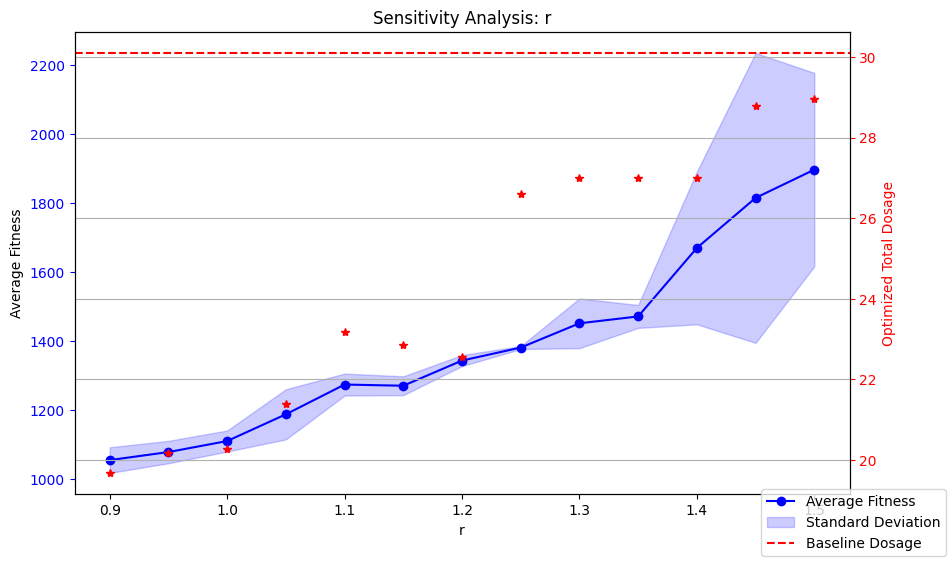

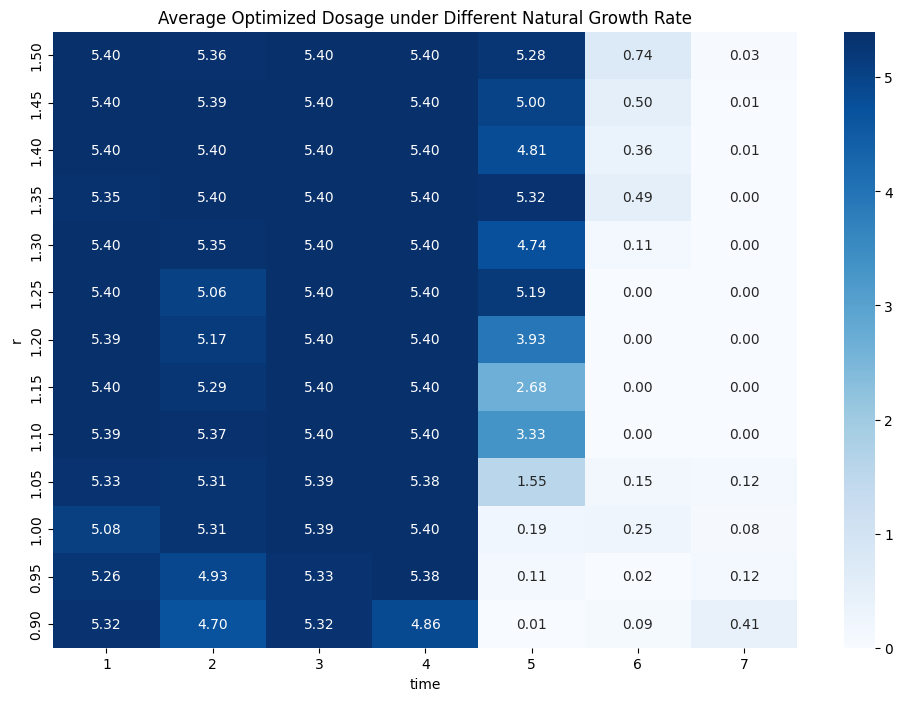

In [13]:
r_values = np.arange(0.90, 1.55, 0.05)
sensiticity_results_r = sensitivity_analysis(ga_params,params, 'r', r_values, num_runs = 10)

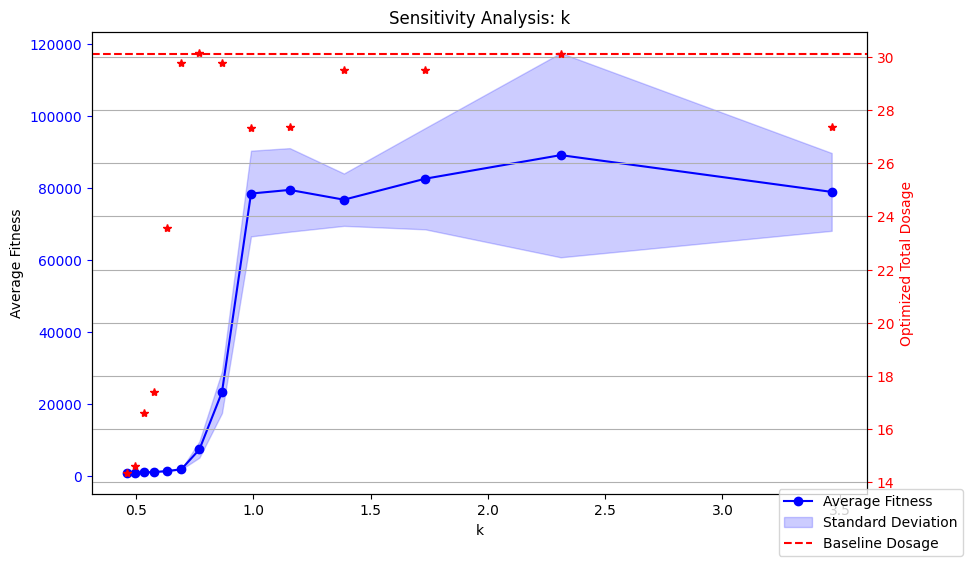

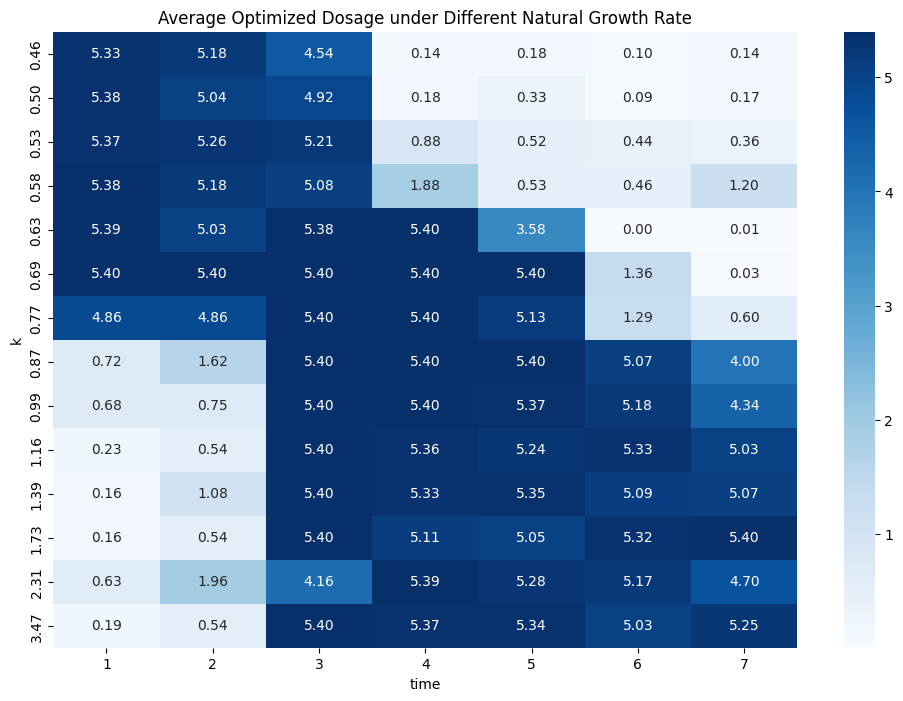

In [14]:
k_values = np.log(2)/np.arange(0.2, 1.6, 0.1)
sensiticity_results_k = sensitivity_analysis(ga_params,params, 'k', k_values, num_runs = 10)